## Data Gathering for the AGN Classifaction Project

Data for this project comes from three primary sources: 

1. The MOJAVE website, this gives basic identifers of the Radio-Loud AGN.
2. The FERMI LAT website, this gives basic idenitifers and gamma-ray photometry for the Gamma-Ray Detected AGN.
3. The NASA Extragalatic Database,  this has extended photometry for the objects in this project.

The work-flow is to use the most effective way possible to download the data and put it into Pandas Dataframes for analysis.

In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import urllib3
import requests
from astroquery.ned import Ned
from time import sleep
import seaborn as sns
from astropy.io import fits
from astropy.table import Table

### MOJAVE Data

After some trial and error I determined that web scrapping was the best way to retrieve the MOJAVe data was to simply scrap the data from its website. The URL of which you see in the line below. MOJAVE maintains an well-maintained set of tables for each version of the MOJAVE survey, that is the MOJAVE sample has increased over the 25 years of its exisitance, so as new sources meet the selection criteria and are brought into the the sample, a new table is formed. Old tables are maintained for reproducibilty of past experiments. 

My first attempt to webscrape,  I used BeautifulSoup, but found that to be overly complicated, as just using Pandas .read_html() method worked just as well and in fewer lines of code.

In [2]:
mojave_url = "http://www.physics.purdue.edu/astro/MOJAVE/MOJAVE1.5JyQC.html"

In [3]:
#soup = BeautifulSoup(mojave_site.content, 'html.parser')
#print(soup.prettify())

In [4]:
#https://stackoverflow.com/questions/2935658/beautifulsoup-get-the-contents-of-a-specific-table
#table = soup.find(lambda tag: tag.name=='table' and tag.has_attr('id') and tag['id']=="myTable") 
#rows = table.findAll(lambda tag: tag.name=='tr')

In [5]:
agn_table = pd.read_html(mojave_url,skiprows = 3)[0]

In [6]:
agn_table  =agn_table.iloc[:232,0:10] 

In [7]:
agn_table.head()

,B1950 Name,J2000 Name,Common Name,Right Asc. (J2000),Declination (J2000),z,Opt. ID,SED Class,Radio Spectrum,Fermi 3FGL Name
0,0003-066,J0006-0623,NRAO 005,00 06 13.893,- 06 23 35.335,0.3467,B,LSP,Flat,NaN
1,0007+106,J0010+1058,III Zw 2,00 10 31.006,+ 10 58 29.504,0.0893,G,LSP,Flat,NaN
2,0016+731,J0019+7327,S5 0016+73,00 19 45.786,+ 73 27 30.018,1.781,Q,LSP,Flat,NaN
3,0048-097,J0050-0929,PKS 0048-09,00 50 41.317,- 09 29 05.210,0.635,B,ISP,Flat,J0050.6-0929
4,0059+581,J0102+5824,TXS 0059+581,01 02 45.762,+ 58 24 11.137,0.644,Q,LSP,Flat,J0102.8+5825


### AGN Naming

A note on AGN naming conventions. A challenge of this study is that there are several different naming conventions. As you can see in the above head of the agn_table, four different columns are for different names of the same object. I give a breif description of the names below.

B1950 Names are derived from the Right Assention and Declination of the AGN during the year 1950 CE. Right Ascention is the angular position of a celestial object starting at the March Equinox (The point the Sun crosses the Celestial Equator in March) and proceding east. It is presented as a time on a Twenty Four Hour clock, such that 1200 RA is 180^o^ from the March Equinox and is consquentally, the September Equinox. The June Solstice is 0900 RA and December Solstice is 1800 RA. 

Declination is an agular measure of how far from the Celestial Equator you are North or South. Northern Declinations are positive and range from 0^o to 90^o, such that stars that appear directly overhead at the Equator have Dec 0 and Polaris, the North Star has a Dec of +89° 15′ 50.8″ nearly aligned which Earth's North Pole. Southern Stars have 0 to negative 90^o declination.

The interpretation of RA and Dec together is they tell you when, and at what Latitude an object reaches its highest point in the sky with respect to the March Equinox. 

In this sence AGN 0003-066 will, on the day of the March Equinox, reach its highest point in the sky 3 minutes after the Equinox, and will appear directly overhead at Latitude 6.6^o^ South. This also means, that if you want to image 0003-066 at night, it's best to do so in the late September. In this way, astronomers name these objects by location, and that location system gives the time for best optical viewing.

The J2000 Name also uses the RA and Dec system, however since the Earth processes in its rotation, the RA and DEC of the Equinoxes and Soltistices changes. J2000 is an updates the system relative to the year 2000 CE. It also takes the declination out to an additional decimal ppoint such that DEC -0623 is 6.23^o South.

The Fermi 3FGL names are the J2000 names, but with an addition significant figure in RA. Common names are names used by older surveys often B1950 names with the survey initials. 

I will use B1950 names for the MOJAVE queries and Fermi 3FGL names for Fermi/LAT queries.

In [8]:
agn_table.dtypes

B1950 Name             object
J2000  Name            object
Common  Name           object
Right Asc. (J2000)     object
Declination (J2000)    object
z                      object
Opt. ID                object
SED Class              object
Radio  Spectrum        object
Fermi 3FGL  Name       object
dtype: object

In [9]:
agn_table['z'] = agn_table['z'].astype(float)

In [10]:
agn_table.describe()

,z
count,213.000000
mean,1.048022
std,0.700587
min,0.004360
25%,0.523000
50%,0.927000
75%,1.419000
max,3.396000


### Redshift 'z'

In 1929, Edwin Hubble discovered that galaxies beyond our own local group where moving away from the Milky Way, and that the further they were, the faster they moved. He did this by examining the distance-luminosity relationship of cephied varibable stars, which have a well defined relationship between thier luminosity and the period of their variablity. 

A consquence of the Hubble Law is that all light from distant galaxies is Doppler-shifted to long wavelenghts, the 'Red' end in the visable spectrum. The further away, the greater the shift to the red end. We call this 'Redshift' and is conventionaly given the letter 'z' as an algebriac symbol.

Redshift is used a a proxy measure for distance, since the meaning of 'distance' becomes very esoteric in an expanding universe with curved space-time. One such esoteric measure of distance that I may need to use is 'luminosity distance': the distance parameter needed to convert Flux Density, the amount of light power incident on a telescope per area per frequency, to Luminosity, the actual power-output of the object at a given frequency of light.

Note that light is taken to mean any electromagnetic radiation, and not just the narrow band human eyes can detect. So, both Radio waves and Gamma-rays are light.

The maximum redshift of 3.396 coresponds to a luminosity distance of 30095.0 Mpc where an Mpc is a Megaparsec or 3.26 million light-years. Luminosity distances may imply greater light travel times than the age of the universe because you have to 'lead the target'. The smallest z, 0.004360 cooresponds to a luminosity distance of 18.8 Mpc and the mean z= 1.048022 to 7103.3 Mpc. I used Ned Wright's cosmological calculator, http://www.astro.ucla.edu/~wright/CosmoCalc.html to make these calculations. 

C:\Users\Nate\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


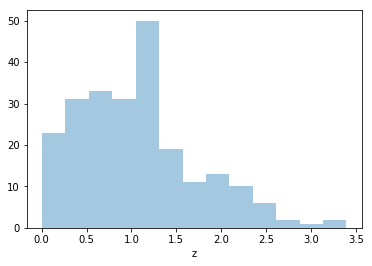

In [11]:
sns.distplot(agn_table['z'].fillna(agn_table['z'].mean()), kde=False)

### Optical IDs

In the seaboarn count plot below we can see that the MOJAVE Quarter Century Survey Consists of largely Quasars (Q) at N = 177, then BL Lac Objects at N = 38 and then Radio Galaxies at N= 10, unknown at N = 6 and a single Seyfert 1 Narrow Line galaxy, a radio quiet galaxy.

In [46]:
agn_table['Opt. ID'].value_counts()

Q    177
B     38
G     10
U      6
N      1
Name: Opt. ID, dtype: int64

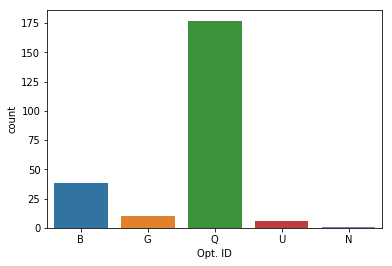

In [12]:
sns.countplot(agn_table['Opt. ID'])

In [13]:
#agn_table.to_excel("MojaveTable.xlsx")

In [14]:
#agn_table.to_excel("MojaveData.xlsx")

## Fermi LAT Data

My first attempt to retrieve Fermi LAT data, from the Fermi Gamma-Ray observatory, was to simply go to their website and query an online data base to retrieve the basic identification data. However, the database seemed to cut off at a Right Ascention of 1417.4. This means that any object with a greater RA, up to RA 2359.9 would be excluded from the analysis set.

In [15]:
lat1_df = pd.read_csv(r"C:\Users\Nate\Documents\DataSet\lat1.txt")
#lat1_df['Source Name'] = lat1_df['Source Name'].str.replace('3FGL ', '')
lat1_df.tail()

,Source Name,Association,RA,Dec,Gal l,Gal b,Average Significance,Flux Density 1-100 GeV(photons cm-2s-1MeV-1),+/-,Flux 1-100 GeV(photons cm-2s-1),...,Spectral Index,+/-.2,Variability Index,Classification (code),TEV Cat,TEV Association,Catalog Flags,Light Curve(Likelihood),Spectrum,DataAccess
1728,3FGL J1415.0-1001,PKS B1412-096,213.756,-10.0184,334.38200,47.6840,4.07216,6.656120e-13,1.539230e-13,2.876690e-10,...,2.49432,0.151407,44.0775,fsrq,N,NaN,0,Link,Link,Link
1729,3FGL J1415.2+4832,RX J1415.5+4830,213.811,48.5396,91.34380,63.1283,6.71311,1.891750e-12,2.929240e-13,2.210100e-10,...,2.66851,0.155441,53.9358,bll,N,NaN,0,Link,Link,Link
1730,3FGL J1416.0+1325,PKS B1413+135,214.006,13.4264,2.39506,65.9579,9.29401,8.838460e-13,1.138160e-13,5.304870e-10,...,2.36344,0.106037,83.2681,bcu,N,NaN,0,Link,Link,Link
1731,3FGL J1416.1-2417,NVSS J141612-241812,214.039,-24.2989,326.53100,34.6608,7.59085,3.217210e-14,6.132630e-15,4.679720e-10,...,1.85276,0.129474,41.6441,bll,N,NaN,0,Link,Link,Link
1732,3FGL J1417.5-4402,NaN,214.377,-44.0427,318.86400,16.1502,12.55370,1.244730e-12,1.238270e-13,9.650950e-10,...,2.36881,0.082212,54.9807,NaN,N,NaN,0,Link,Link,Link


In [16]:
lat1_df.dtypes

Source Name                                      object
Association                                      object
RA                                              float64
Dec                                             float64
Gal l                                           float64
Gal b                                           float64
Average Significance                            float64
Flux Density 1-100 GeV(photons cm-2s-1MeV-1)    float64
+/-                                             float64
Flux 1-100 GeV(photons cm-2s-1)                 float64
+/-.1                                           float64
Spectral Type                                    object
Spectral Index                                  float64
+/-.2                                           float64
Variability Index                               float64
Classification (code)                            object
TEV Cat                                          object
TEV Association                                 

In [17]:
lat1_df.describe()

,RA,Dec,Gal l,Gal b,Average Significance,Flux Density 1-100 GeV(photons cm-2s-1MeV-1),+/-,Flux 1-100 GeV(photons cm-2s-1),+/-.1,Spectral Index,+/-.2,Variability Index,Catalog Flags
count,1733.000000,1733.000000,1733.000000,1733.000000,1733.000000,1.733000e+03,1.733000e+03,1.733000e+03,1.733000e+03,1733.000000,1733.000000,1733.000000,1733.000000
mean,112.142770,-1.436921,215.338209,3.657645,-inf,1.532846e-11,-inf,2.710372e-09,-inf,2.217368,-inf,139.142802,21.265436
std,62.776027,42.186467,68.060072,40.315180,NaN,2.833953e-10,NaN,3.568620e-08,NaN,0.349014,NaN,583.312911,144.861752
min,0.037700,-87.618500,1.251670,-87.951600,-inf,4.215150e-16,-inf,4.905820e-12,-inf,0.500024,-inf,0.000000,0.000000
25%,55.849700,-37.935700,155.931000,-23.747200,5.496990,1.000010e-13,1.603680e-14,3.211970e-10,7.205570e-11,1.995210,0.082467,41.729400,0.000000
50%,117.178000,-1.773100,218.335000,1.707190,7.854710,5.682030e-13,7.773720e-14,5.369980e-10,9.015690e-11,2.249310,0.122798,51.035200,0.000000
75%,166.305000,33.489900,276.643000,34.690600,13.537300,2.505520e-12,2.717860e-13,1.096810e-09,1.266770e-10,2.457400,0.162197,68.791300,0.000000
max,214.377000,87.600000,358.672000,86.367900,1048.960000,1.144760e-08,6.864760e-10,1.297680e-06,2.893960e-09,5.715890,0.499087,18067.400000,2056.000000


### Fermi FITS Table

My next method was to download the entire sample as a FITS table. FITS stands for Flexible Image Transport System and is the standard file format in astronmy. Since the case use is very specialized transfering the data into a Pandas format is a multi-step process. The Python library Astropy has a function for reading fits data into an Astropy table which is preformed below.

In [18]:
lat2_table = fits.open('gll_psc_v16.fit')
lat2_table
lat2_data = lat2_table[1].data

Unfortunately, the photometry data included in the fits table has a formatting issue that prevents it from being directly transferred to a Pandas Dataframe. An ad hoc soulution is to drop the problematic columns and then convert to a dataframe below. A fruitful future project could be to create a function that would allow the tranffer of the data directly, Astronomy suffers from using it's own specialized formats and software, and this makes using more modern and powerful analysis tools difficult. A lot of valuable time is lost in munging data that is stored in formats that made sense 40 years ago, and by cognative inertia has never been standardized to more general formats. 

In [106]:
table = Table.read('gll_psc_v16.fit')
table.remove_columns(['Unc_Flux100_300', 'Unc_Flux300_1000', 'Unc_Flux1000_3000', 'Unc_Flux3000_10000', 'Unc_Flux10000_100000', 'Flux_History', 'Unc_Flux_History'])
lat2_df = table.to_pandas()

In [117]:
lat2_df.to_excel("gll_psc_v16.xlsx")

In [107]:
lat2_df.tail()
#lat2_data[:2]

,Source_Name,RAJ2000,DEJ2000,GLON,GLAT,Conf_68_SemiMajor,Conf_68_SemiMinor,Conf_68_PosAng,Conf_95_SemiMajor,Conf_95_SemiMinor,...,1FHL_Name,ASSOC_GAM1,ASSOC_GAM2,ASSOC_GAM3,TEVCAT_FLAG,ASSOC_TEV,CLASS1,ASSOC1,ASSOC2,Flags
3029,b'3FGL J2358.5+3827 ',359.634186,38.453899,111.687180,-23.259953,0.062228,0.046070,79.940002,0.1009,0.0747,...,b' ',b' ',b' ',b' ',b'N',b' ',b' ',b' ',b' ',0
3030,b'3FGL J2358.6-1809 ',359.665894,-18.158501,66.603561,-74.894989,0.044528,0.039409,19.879999,0.0722,0.0639,...,b' ',b' ',b' ',b' ',b'N',b' ',b' ',b' ',b' ',0
3031,b'3FGL J2358.9+3926 ',359.735992,39.447601,112.008080,-22.308020,0.107866,0.087884,10.360000,0.1749,0.1425,...,b' ',b' ',b' ',b' ',b'N',b' ',b'fsrq ',b'B2 2356+39 ',b' ',0
3032,b'3FGL J2359.3-3038 ',359.829102,-30.646500,12.706573,-78.069862,0.033488,0.031391,-6.680000,0.0543,0.0509,...,b'1FHL J2359.2-3037 ',b' ',b' ',b' ',b'P',b'H 2356-309 ',b'bll ',b'H 2356-309 ',b' ',0
3033,b'3FGL J2359.5-2052 ',359.881195,-20.882601,57.947227,-76.611977,0.052915,0.044898,-22.459999,0.0858,0.0728,...,b' ',b' ',b' ',b' ',b'N',b' ',b'bll ',b'TXS 2356-210 ',b' ',0


In [108]:
# just needed to conver the source name from a byte string to a regualr string.
lat2_df['Source_Name']=lat2_df['Source_Name'].str.decode("utf-8")
lat2_df.head()

,Source_Name,RAJ2000,DEJ2000,GLON,GLAT,Conf_68_SemiMajor,Conf_68_SemiMinor,Conf_68_PosAng,Conf_95_SemiMajor,Conf_95_SemiMinor,...,1FHL_Name,ASSOC_GAM1,ASSOC_GAM2,ASSOC_GAM3,TEVCAT_FLAG,ASSOC_TEV,CLASS1,ASSOC1,ASSOC2,Flags
0,3FGL J0000.1+6545,0.0377,65.751701,117.693878,3.402958,0.062845,0.048105,41.029999,0.1019,0.0780,...,b' ',b' ',b' ',b' ',b'N',b' ',b' ',b' ',b' ',4
1,3FGL J0000.2-3738,0.0612,-37.648399,345.410522,-74.946754,0.045083,0.041691,-88.550003,0.0731,0.0676,...,b' ',b' ',b' ',b' ',b'N',b' ',b' ',b' ',b' ',0
2,3FGL J0001.0+6314,0.2535,63.243999,117.293091,0.925701,0.152640,0.098553,-65.320000,0.2475,0.1598,...,b' ',b' ',b' ',b' ',b'N',b' ',b'spp ',b' ',b' ',28
3,3FGL J0001.2-0748,0.3209,-7.815900,89.022202,-67.324249,0.050325,0.042924,-19.469999,0.0816,0.0696,...,b' ',b' ',b' ',b' ',b'N',b' ',b'bll ',b'PMN J0001-0746 ',b' ',0
4,3FGL J0001.4+2120,0.3612,21.337900,107.665428,-40.047157,0.129821,0.116191,-32.549999,0.2105,0.1884,...,b' ',b' ',b'3EG J2359+2041',b' ',b'N',b' ',b'fsrq ',b'TXS 2358+209 ',b' ',0


### Fermi LAT Classifications 

In the count plot below we see that the FERMI LAT survey has a much broader number of objects than MOJAVE. This is no surprise as the FERMI LAT's selection crieria is mearly detection and MOJAVE's was set to isololate Blazars. What is of concern, however is that the data was input without respect to letter case, so 'BLL' and 'bll' will be seen as seperate classes to Pandas. I used the .replace() method to unify all agn classes.

[Text(0,0,'blank'),
 Text(0,0,'spp  '),
 Text(0,0,'BLL  '),
 Text(0,0,'FSRQ '),
 Text(0,0,'bcu  '),
 Text(0,0,'PSR  '),
 Text(0,0,'glc  '),
 Text(0,0,'snr  '),
 Text(0,0,'GAL  '),
 Text(0,0,'sbg  '),
 Text(0,0,'BCU  '),
 Text(0,0,'HMB  '),
 Text(0,0,'psr  '),
 Text(0,0,'rdg  '),
 Text(0,0,'RDG  '),
 Text(0,0,'nlsy1'),
 Text(0,0,'ssrq '),
 Text(0,0,'pwn  '),
 Text(0,0,'PWN  '),
 Text(0,0,'SNR  '),
 Text(0,0,'NLSY1'),
 Text(0,0,'BIN  '),
 Text(0,0,'AGN  '),
 Text(0,0,'css  '),
 Text(0,0,'sey  '),
 Text(0,0,'SFR  '),
 Text(0,0,'NOV  ')]

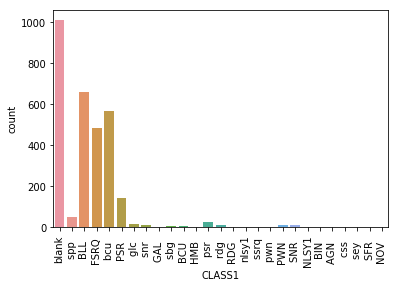

In [116]:
g = sns.countplot(lat2_df['CLASS1'])
g.set_xticklabels(g.get_xticklabels(),rotation=90)

### Fermi LAT Data Exploration

Below are some histograms for data inlcuded in the table retrieved from the Fermi/LAT Website. We first see that there are some extreme outliers in the Gamma-ray Flux Density. These may be assoicated with Super Nova Remenants and are beyond the scope of this study. Handling of these outliers will be done in the next section.  

C:\Users\Nate\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


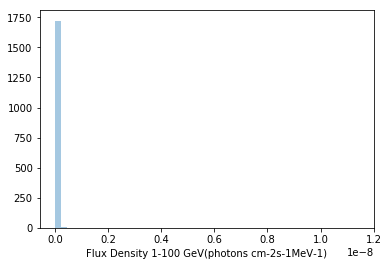

In [23]:
sns.distplot(lat1_df['Flux Density 1-100 GeV(photons cm-2s-1MeV-1)'], kde=False)

Next is spectral index. Many sources, such as AGN show non-thermal spectra that can best be fitted with a power-law in a luminosity (L) vs wavelength (l) (or frequency (f) or photon energy: E = hf = hc/l, h is Plank's Constant, c is speed of light) domain. Here we see what appears to be close to a Normal Distribution with a mode at about 2.5. 

C:\Users\Nate\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


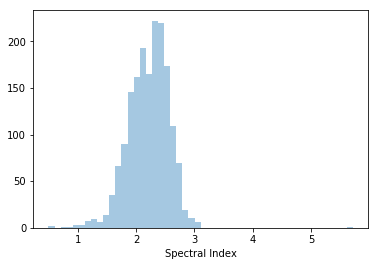

In [24]:
sns.distplot(lat1_df['Spectral Index'], kde=False)

For Right Ascention and Declination we see that Fermi LAT has a fairly uniform distribution with respect to RA, but tends to fall off near the Celestial Poles. Note that Fermi is a space telescope, since the Earth;s Atmsophere is opaque to gamma-rays, as such it orbits around the Celestial Equator and may have difficulty slewing toward the poles.

C:\Users\Nate\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


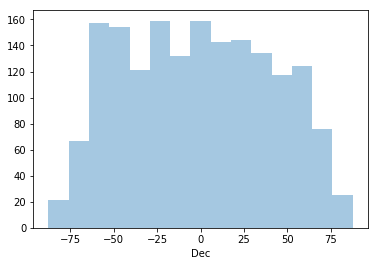

In [25]:
sns.distplot(lat1_df['Dec'], kde=False)

C:\Users\Nate\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


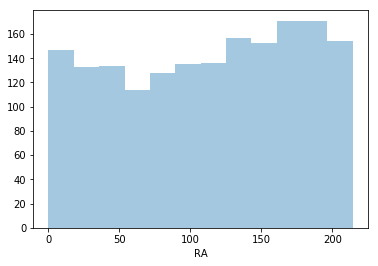

In [26]:
sns.distplot(lat1_df['RA'], kde=False)

Variability Index is a measure of how much variation a source's luminosity can vary, https://academic.oup.com/mnras/article/400/4/1897/1079176.  We see the data is skewed by low percentage of sources that have high variability. This will be reeximined in the next section, when we slice the data to only include AGN type sources. 

C:\Users\Nate\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


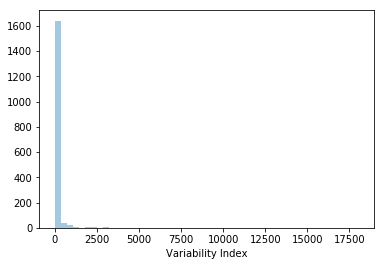

In [27]:
sns.distplot(lat1_df['Variability Index'], kde=False)

In [28]:
lat1_df.shape

(1733, 22)

## Retreiving Photometric Data

The final step of this part of the study is to retrieve photometric data for each source. Photometric data combines all flux denity data available for each source. That is the brightness measure at a specified wavelength of light for each telescopicv measurement available. I used NASA's Extragalactic Database to get the data. 

Astropy has a function for retieiving data from NED, https://astroquery.readthedocs.io/en/latest/ned/ned.html. The NED website wanrs that NED is not optimized for large batch queries, https://ned.ipac.caltech.edu/Documents/Guides/Interface/QueryAuto, to help accomadate this I built in a 10s delay into the loop.

Ultimately, I was able to retrieve photometry for 231 out of 232 MOJAVE sources, but only 486 Fermi/LAT sources. Improving the NED query loop to include a larger amount of Fermi sources is the top priority for the future of this study.

In [29]:
photo_df = pd.DataFrame()
name_list = list()
for name in agn_table["B1950 Name"]:    
    print(name)
    #"""
    try:
        ned_table = Ned.get_table(name, table='photometry')
        #ned_name_url = "https://ned.ipac.caltech.edu/srs/ObjectLookup?name={}".format(name)
    except:
        continue    
    ned_table[0]
    ned_df = ned_table.to_pandas()
    ned_df.iloc[:,1] = ned_df.iloc[:,1].str.decode("utf8")
    ned_df = ned_df.transpose()
    ned_df = ned_df.drop(ned_df.index[0])
    ned_df =ned_df.rename(columns=ned_df.iloc[0])
    ned_df = ned_df.drop(ned_df.index[0])
    ned_df = ned_df.iloc[[4]]
    #print(ned_df)
    ned_df = ned_df.loc[:,~ned_df.columns.duplicated()]
    photo_df = photo_df.loc[:,~photo_df.columns.duplicated()]
    photo_df = pd.concat([photo_df,ned_df], axis=0, ignore_index=True)
    name_list.append(name)
    sleep(1)
    #"""
photo_df["Source Name"] = name_list

0003-066
0007+106


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0016+731


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0048-097


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0059+581


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0106+013


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0109+224


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0109+351


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0113-118


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0119+115


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0122-003


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0125+487


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0130-171


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0133+476


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0135-247


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0149+218


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0202+149


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0202+319


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0202-172


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0208+106


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0212+735


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0215+015


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0221+067


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0224+671


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0229+131


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0234+285


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0235+164


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0237-027


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0238-084


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0241+622


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0300+470


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0306+102


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0316+413


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0322+222


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0333+321


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0336-019


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0355+508


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0400+258


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0403-132


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0415+379


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0420+022


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0420+417


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0420-014


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0422+004


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0430+052


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0440-003


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0446+112


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0451-282


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0454-234


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0458-020


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0507+179


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0509+406


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0528+134


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0529+075


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0529+483


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0537-286


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0539-057


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0552+398


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0605-085


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0607-157


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0627-199


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0642+449


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0646-176


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0648-165


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0653-033


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0657+172


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0700-197


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0716+714


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0723-008


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0727-115


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0735+178


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0736+017


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0738+313


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0742+103


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0743-006


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0745+241


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0748+126


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0754+100


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0804+499


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0805+410


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0805-077


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0808+019


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0814+425


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0821+394


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0823+033


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0823-223


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0827+243


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0829+046


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0834-201


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0836+710


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0838+133


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0847-120
0851+202


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0859-140


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0906+015


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0917+449


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0917+624


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0919-260


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0923+392


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0925-203


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0945+408


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0953+254


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0954+658


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



0955+476


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1030+415


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1030+611


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1034-293


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1036+054


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1038+064


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1040+244


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1044+719


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1045-188


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1053+704


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1055+018


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1124-186


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1127-145


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1128+385


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1144+402


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1149-084


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1150+497


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1150+812


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1156+295


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1213-172


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1219+044


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1222+216


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1226+023


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1228+126


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1243-160


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1244-255


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1253-055


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1302-102


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1308+326


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1324+224


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1329-049


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1334-127


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1406-076


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1413+135


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1417+385


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1418+546


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1435+638


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1458+718


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1502+106


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1504-166


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1510-089


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1511-100


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1514+197


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1514-241


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1519-273


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1538+149


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1546+027


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1548+056


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1606+106


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1611+343


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1622-253


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1622-297


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1633+382


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1637+574


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1638+398


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1639-062


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1641+399


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1642+690


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1655+077


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1657-261


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1726+455


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1730-130


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1739+522


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1741-038


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1742-078


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1749+096


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1751+288


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1758+388


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1800+440


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1803+784


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1807+698


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1823+568


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1828+487


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1842+681


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1846+322


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1849+670


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1908-201


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1920-211


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1921-293


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1923+210


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1928+738


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1936-155


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1954+513


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1957+405


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



1958-179


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



2005+403


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



2007+777


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



2008-159


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



2010+463


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



2013+370


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



2021+317


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



2021+614


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



2022-077


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



2023+335


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



2029+121


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



2037+511


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



2059+034


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



2121+053


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



2126-158


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



2128-123


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



2131-021


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



2134+004


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



2136+141


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



2141+175


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



2144+092


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



2145+067


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



2155-152


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



2200+420


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



2201+171


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



2201+315


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



2209+236


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



2214+241


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



2216-038


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



2223+210


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



2223-052


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



2227-088


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



2230+114


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



2234+282


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



2241+406


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



2243-123


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



2251+158


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



2255-282


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



2320-035


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



2325+093


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



2331+073


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



2331-240


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



2345-167


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



2351+456


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



2355-106


C:\Users\Nate\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



In [30]:
photo_df.head()
#ned_name_site = requests.get(ned_name_url,"lxml")

,0.1-10 GeV (Fermi),0.1-100 GeV (Fermi),0.1-2.4 keV (Fermi),0.1-2.4 keV (ROSAT),0.1-2.4 keV (Swift),0.15-3.5 keV (IPC),0.2 keV (Einstein),0.2-10 keV (Swift),0.2-10 keV (XMM),0.2-2 keV (ROSAT),...,u (SDSS) AB,z (KPNO),z (SDSS CModel) AB,z (SDSS Model) AB,z (SDSS PSF) AB,z (SDSS Petrosian)AB,z (SDSS) AB,z' (GROND) AB,z' (SOAR) AB,Source Name
0,NaN,NaN,NaN,5.32e-07,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0003-066
1,NaN,NaN,NaN,2.03e-06,2.03e-06,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0007+106
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0016+731
3,NaN,3.57e-13,7.72e-07,1.29e-06,NaN,NaN,NaN,NaN,NaN,1.65e-06,...,NaN,NaN,NaN,NaN,0.00211,NaN,NaN,0.00273,NaN,0048-097
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0059+581


In [118]:
photo_df.shape

(231, 1267)

In [31]:
#soup = BeautifulSoup(ned_name_site.content)
#print(soup)

In [45]:
photo_df.to_excel("MojavePhotometry.xlsx")

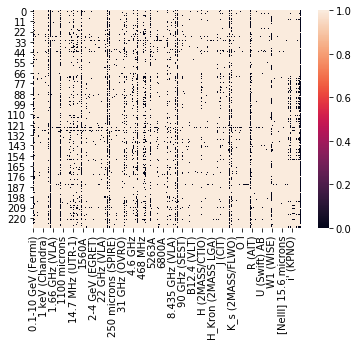

In [33]:
photo_df.fillna(value=np.nan, inplace=True)
g=sns.heatmap(photo_df.isnull())

We see in the above Seaborn Heatmap that the Photometry data is very sparse. There are certain wavelengths that are well covered, but other wavelegnths are barely covered. We also see that certain sources have greater coverage than others.

These biases in data coverage are a potential area of future work. What are we missing with respect to the behavoir of these objects is missed, just because we have not looked?

In [34]:
#lat_names = [] 
#[lat_names.append(x) for x in lat_list if x not in lat_names] 
#len(lat_names)

NameError: name 'lat_list' is not defined

In [ ]:
#lat_list = lat_names

In [39]:
#photoLAT_df = pd.DataFrame()
#lat_list = []
for name in lat2_df["Source_Name"]:    
    if name not in lat_list:
        #"""
        try:
            lat_table = Ned.get_table(name, table='photometry')
            lat_list.append(name)
            sleep(10)
        except:
            sleep(10)
            continue
        lat_table[0]
        lat_df = lat_table.to_pandas()
        lat_df.iloc[:,1] = lat_df.iloc[:,1].str.decode("utf8")
        lat_df = lat_df.transpose()
        lat_df = lat_df.drop(lat_df.index[0])
        lat_df =lat_df.rename(columns=lat_df.iloc[0])
        lat_df = lat_df.drop(lat_df.index[0])
        lat_df = lat_df.iloc[[4]]
        #print(lat_df)
        lat_df = lat_df.loc[:,~lat_df.columns.duplicated()]
        photoLAT_df = photoLAT_df.loc[:,~photoLAT_df.columns.duplicated()]
        photoLAT_df = pd.concat([photoLAT_df,lat_df], axis=0, ignore_index=True)
    
    #"""
photoLAT_df["Source Name"] = lat_list

In [114]:
lat2_df['CLASS1']

0       blank
1       blank
2       spp  
3       bll  
4       fsrq 
5       blank
6       blank
7       bcu  
8       blank
9       bcu  
10      blank
11      blank
12      bcu  
13      blank
14      blank
15      fsrq 
16      blank
17      fsrq 
18      blank
19      PSR  
20      blank
21      blank
22      bll  
23      blank
24      blank
25      bll  
26      blank
27      bll  
28      bll  
29      bcu  
        ...  
3004    bll  
3005    bcu  
3006    fsrq 
3007    bcu  
3008    bll  
3009    blank
3010    bll  
3011    bcu  
3012    blank
3013    bll  
3014    bcu  
3015    blank
3016    fsrq 
3017    blank
3018    blank
3019    blank
3020    fsrq 
3021    bll  
3022    blank
3023    bll  
3024    bll  
3025    fsrq 
3026    fsrq 
3027    fsrq 
3028    bcu  
3029    blank
3030    blank
3031    fsrq 
3032    bll  
3033    bll  
Name: CLASS1, Length: 3034, dtype: object

In [111]:
lat2_df['CLASS1']=lat2_df['CLASS1'].replace(b'     ', b'blank')

In [113]:
lat2_df['CLASS1']=lat2_df['CLASS1'].str.decode("utf-8")

In [115]:
lat2_df['CLASS1']=lat2_df['CLASS1'].replace('bll  ', 'BLL  ')
lat2_df['CLASS1']=lat2_df['CLASS1'].replace('fsrq ', 'FSRQ ')
lat2_df['CLASS1']=lat2_df['CLASS1'].replace('agn  ', 'AGN  ')
lat2_df['CLASS1']=lat2_df['CLASS1'].replace('gal  ', 'GAL  ')

In [40]:
photoLAT_df.head()

,0.1-100 GeV (Fermi),0.1-2 keV (XMM),0.1-2.4 keV (Fermi),0.1-2.4 keV (ROSAT),0.1-2.4 keV (Swift),0.13-0.18 keV (EUVE),0.15-3.5 keV (IPC),0.2 keV (Einstein),0.2-10 keV (Swift),0.2-10 keV (XMM),...,u (SDSS) AB,z (KPNO),z (SDSS CModel) AB,z (SDSS Model) AB,z (SDSS PSF) AB,z (SDSS Petrosian)AB,z (SDSS) AB,z' (GROND) AB,z' (SOAR) AB,Source Name
0,2.11e-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3FGL J0009.3+5030
1,1.6e-13,NaN,2.66e-07,4.11e-07,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3FGL J0017.6-0512
2,4.3e-14,NaN,NaN,1.95e-06,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3FGL J0018.4+2947
3,8.35e-14,NaN,NaN,2.23e-06,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3FGL J0018.9-8152
4,2.04e-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3FGL J0022.5+0608


In [44]:
photoLAT_df.to_excel("LATPhotometry.xlsx")

In [41]:
len(lat_list)

486

In [42]:
photoLAT_df.shape

(486, 1485)

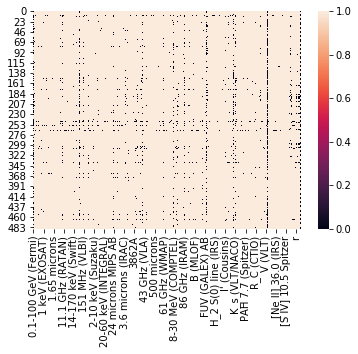

In [43]:
photoLAT_df.fillna(value=np.nan, inplace=True)
sns.heatmap(photoLAT_df.isnull())

We see that the FERMI/LAT coverage is even sparser than MOJAVE with the same bands of high coverage with respect to wavelengths and sources.